# 📧 Spam Email Classifier (Naive Bayes Model)
This notebook loads raw `.eml` files from folders, processes and trains a spam classifier using a Naive Bayes model.

In [9]:

import os
import re
import pandas as pd
import numpy as np
from collections import Counter
from email import policy
from email.parser import BytesParser
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib


In [ ]:
# --- AUGMENT SPAM DATA MANUALLY ---
import pandas as pd

augmented_spam = [
    {
        "subject": "URGENT: Account Locked",
        "text": "Your PayPal account is locked. Click here to verify your identity immediately: http://malicious.site"
    },
    {
        "subject": "Reset Your Password Now",
        "text": "We detected suspicious activity in your account. Please reset your password to continue using our service."
    },
    {
        "subject": "System Infected - Scan Now",
        "text": "Antivirus Alert: Your PC is at risk. Immediate action is required to remove detected threats."
    },
    {
        "subject": "Claim Your $1000 Reward",
        "text": "Congratulations! You're selected for a $1000 Walmart Gift Card. Claim now before the link expires."
    },
    {
        "subject": "Your Tax Refund Is Ready",
        "text": "You are eligible for a tax refund. Confirm your bank details to receive the refund."
    }
]

aug_df = pd.DataFrame(augmented_spam)
aug_df["label"] = 1  # spam
df = pd.concat([df, aug_df], ignore_index=True)

df["combined_text"] = df["subject"].fillna('') + ' ' + df["text"].fillna('')
df["cleaned_text"] = df["combined_text"].apply(clean_text)

print("✅ Augmented dataset size:", len(df))


In [10]:

def parse_email(file_path):
    with open(file_path, 'rb') as f:
        msg = BytesParser(policy=policy.default).parse(f)
    headers = dict(msg.items())
    body = msg.get_body(preferencelist=('plain', 'html'))
    return {
        "subject": headers.get("Subject", ""),
        "body": body.get_content() if body else ""
    }

def load_emails_from_folder(folder_path, label):
    emails = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        try:
            parsed = parse_email(file_path)
            emails.append({
                "subject": parsed["subject"],
                "text": parsed["body"],
                "label": label
            })
        except Exception:
            continue
    return emails

def clean_text(text):
    text = re.sub(r'\b\d+\b', ' ', text)
    text = re.sub(r'\b(?:\d{1,2}[: ]\d{2})\b', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


In [11]:
ham_emails = load_emails_from_folder("easy_ham", 0)
spam_emails = load_emails_from_folder("spam", 1)
spam2_emails = load_emails_from_folder("spam_2", 1)


all_emails = pd.DataFrame(ham_emails + spam_emails + spam2_emails)
all_emails['subject'] = all_emails['subject'].fillna('')
all_emails['text'] = all_emails['text'].fillna('')
all_emails['combined_text'] = all_emails['subject'] + ' ' + all_emails['text']
all_emails['cleaned_text'] = all_emails['combined_text'].apply(clean_text)

print(f"📬 Total emails loaded: {len(all_emails)}")
print(f"✅ Ham emails: {len(all_emails[all_emails['label'] == 0])}")
print(f"🚫 Spam emails: {len(all_emails[all_emails['label'] == 1])}")


📬 Total emails loaded: 4015
✅ Ham emails: 2501
🚫 Spam emails: 1514


In [12]:

X = all_emails['cleaned_text']
y = all_emails['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
from sklearn.linear_model import LogisticRegression

nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_df=0.95,
        min_df=2,
        max_features=5000,
        ngram_range=(1, 2),  # Unigrams + bigrams
        stop_words='english',
        sublinear_tf=True,
        strip_accents='unicode',
        lowercase=True
    )),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

nb_pipeline.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, ngram_range=(1, 3),
                                 stop_words='english', strip_accents='unicode',
                                 sublinear_tf=True)),
                ('clf', MultinomialNB())])


Classification Report:

              precision    recall  f1-score   support

           0     0.9542    1.0000    0.9766       500
           1     1.0000    0.9208    0.9588       303

    accuracy                         0.9701       803
   macro avg     0.9771    0.9604    0.9677       803
weighted avg     0.9715    0.9701    0.9698       803



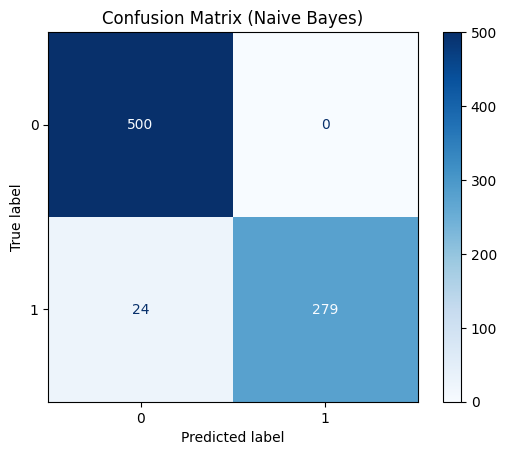

In [14]:

y_pred = nb_pipeline.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Naive Bayes)")
plt.show()


In [17]:
# --- ANALYZE FALSE NEGATIVES (Missed Spam) ---
false_negatives_idx = np.where((y_test.values == 1) & (y_pred == 0))[0]
filename = "false_negatives.txt"

with open(filename, "w", encoding="utf-8") as f:
    f.write(f"Total false negatives (missed spam): {len(false_negatives_idx)}\n\n")
    for idx in false_negatives_idx:
        orig_idx = X_test.index[idx]
        f.write(f"--- Email index in test set: {idx} ---\n")
        f.write(f"Email Subject: {all_emails.iloc[orig_idx]['subject']}\n")
        f.write(f"Email Text: {all_emails.iloc[orig_idx]['combined_text']}\n")
        f.write(f"Actual Label: Spam\n")
        f.write(f"Predicted Label: Ham\n")
        f.write("-" * 50 + "\n")

print(f"✅ False negatives saved to: {filename}")


✅ False negatives saved to: false_negatives.txt


In [16]:
# --- TEST SAMPLE EMAILS ---
nb_pipeline = joblib.load("spam_detector_nb_model.pkl")
sample_emails = [
    {"subject": "Team Meeting Reminder", "body": "Dear team, this is a reminder for our meeting tomorrow at 10am in room 305."},
    {"subject": "Invoice Attached", "body": "Hi, please find attached the invoice for last month. Let me know if you have any questions."},
    {"subject": "Assignment Feedback", "body": "Your assignment has been marked. Please check the portal for your grade and feedback."},
    {"subject": "Lunch Plans?", "body": "Hey, are you free for lunch today at 1pm? Let me know!"},
    {"subject": "URGENT: Account Locked", "body": "Your account is locked. Verify your info here: http://phishingsite.com"},
    {"subject": "Your payment has been confirmed", "body": "Baseus Presenter Wireless Laser Pointer 2.4GHz Remote Controller for Mac 1 item from Shopee Delivered today Order number 250512NXGU9D17"},
    {"subject": "Your input Matters: Where did you find us?", "body": "Dear customer, Thank you for choosing Toyota! Your trust means the world to us. To help us serve you better, we’d love to get your feedback. Please take a moment to complete a short survey by clicking the link here. Your input will help us enhance our services and improve your overall experience. We promise it will only take a brief of your time. Thank you for your time and continued support! Best regards,   Toyota Customer Relations Team"},
]
print("\nTesting batch of sample emails with Naive Bayes...\n")
for i, email in enumerate(sample_emails, 1):
    combined_text = clean_text(email['subject'] + ' ' + email['body'])
    prediction = nb_pipeline.predict([combined_text])[0]
    print(f"Email {i}")
    print("Subject:", email['subject'])
    print("Prediction:", "Spam" if prediction == 1 else "Ham")
    print("-" * 40)


Testing batch of sample emails with Naive Bayes...

Email 1
Subject: Team Meeting Reminder
Prediction: Ham
----------------------------------------
Email 2
Subject: Invoice Attached
Prediction: Ham
----------------------------------------
Email 3
Subject: Assignment Feedback
Prediction: Ham
----------------------------------------
Email 4
Subject: Lunch Plans?
Prediction: Ham
----------------------------------------
Email 5
Subject: URGENT: Account Locked
Prediction: Ham
----------------------------------------
Email 6
Subject: Your payment has been confirmed
Prediction: Ham
----------------------------------------
Email 7
Subject: Your input Matters: Where did you find us?
Prediction: Spam
----------------------------------------
